In [1]:
import torch
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open('names.txt').read().splitlines()
print(f'total words: {len(words)}')
print(f'total characters: {len("".join(words))}')
print('max length of any word:', max(len(w) for w in words))
words[:5]

total words: 32033
total characters: 196113
max length of any word: 15


['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [3]:
# build vocabulary of characters and encoder/decoder (tokenizer)
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

vocab_size = len(stoi)
print(f'{stoi=}')
print(f'{vocab_size=}')

stoi={'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}
vocab_size=27


In [4]:
# build the dataset
block_size = 3          # context length

def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w+'.':
            X.append(context)
            ix = stoi[ch]
            Y.append(ix)
            context = context[1:] + [ix]
    X, Y = torch.tensor(X), torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xval, Yval = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [5]:
for x, y in zip(Xtr[:20], Ytr[:20]):
    print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

... --> y
..y --> u
.yu --> h
yuh --> e
uhe --> n
hen --> g
eng --> .
... --> d
..d --> i
.di --> o
dio --> n
ion --> d
ond --> r
ndr --> e
dre --> .
... --> x
..x --> a
.xa --> v
xav --> i
avi --> e


In [4]:
# training a deep neural network

class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        # kaiming init
        self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None
    
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
    

class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
        
    def __call__(self, x):
        # forward pass
        if self.training:
            if x.ndim == 2:
                dim = 0
            elif x.ndim == 3:
                dim = (0, 1)
            xmean = x.mean(dim, keepdims=True) # batch mean
            xvar = x.var(dim, keepdims=True)   # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x-xmean) / torch.sqrt(xvar + self.eps) # normalize the batch
        self.out = self.gamma * xhat + self.beta
        # update the buffers
        if self.training:
            with torch.no_grad():     # context manager
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]
    
    
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []
    

class Embedding:
    def __init__(self, num_embedding, embedding_dim):
        self.weight = torch.randn((num_embedding, embedding_dim))
    
    def __call__(self, IX):
        self.out = self.weight[IX]
        return self.out
    
    def parameters(self):
        return [self.weight]
    

class Flatten:
    def __call__(self, x):
        self.out = x.view(x.shape[0], -1)
        return self.out
    def parameters(self):
        return []
    
    
class Sequential():
    def __init__(self, layers):
        self.layers = layers
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [5]:
torch.manual_seed(42);

In [8]:
n_embd = 10
n_hidden = 200

model = Sequential([
    Embedding(vocab_size, n_embd), Flatten(),
    Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden),
    Tanh(),
    Linear(n_hidden, vocab_size),
])

# parameter init
with torch.no_grad():
    # last layer: make less confident
    model.layers[-1].weight *= 0.1
    # all other layers: apply gain
#     for layer in layers[:-1]:
#         if isinstance(layer, Linear):
#             layer.weight *= 5/3

parameters = [p for layer in model.layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in model.parameters():
    p.requires_grad = True

12097


In [9]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # construct minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    # forward pass
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb)
    
    # back prop
#     for layer in layers:
#         layer.out.retain_grad()
    for p in model.parameters():
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in model.parameters():
        p.data += -lr * p.grad
    
    # track stats
    lossi.append(loss.log10().item())
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    break

      0/ 200000: 3.2966


In [ ]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))
plt.xlabel('# iterations (every 1000 training cycle)')
plt.ylabel('avg log-loss');

In [ ]:
for layer in model.layers:
    layer.training = False

In [ ]:
# evaluate the loss
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xval, Yval),
        'test': (Xte, Yte),
    }[split]
    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())
    
split_loss('train')
split_loss('val')
    

In [ ]:
# sample from the model
for _ in range(5):
    out = []
    context = [0] * block_size
    while True:
        logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim=1)
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1).item()
        context = context[1:]+[ix]
        out.append(ix)
        # special token '.', break
        if ix == 0:
            break
            
    print(''.join(itos[i] for i in out))

# LET'S BUILD A WAVENET

In [6]:
# build the dataset
block_size = 8          # context length

def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w+'.':
            X.append(context)
            ix = stoi[ch]
            Y.append(ix)
            context = context[1:] + [ix]
    X, Y = torch.tensor(X), torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xval, Yval = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 8]) torch.Size([182625])
torch.Size([22655, 8]) torch.Size([22655])
torch.Size([22866, 8]) torch.Size([22866])


In [7]:
for x, y in zip(Xtr[:20], Ytr[:20]):
    print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

........ --> y
.......y --> u
......yu --> h
.....yuh --> e
....yuhe --> n
...yuhen --> g
..yuheng --> .
........ --> d
.......d --> i
......di --> o
.....dio --> n
....dion --> d
...diond --> r
..diondr --> e
.diondre --> .
........ --> x
.......x --> a
......xa --> v
.....xav --> i
....xavi --> e


In [8]:
class FlattenConsecutive:
    def __init__(self, n):
        self.n = n
    
    def __call__(self, x):
        B, T, C = x.shape
        x = x.view(B, T//self.n, self.n*C)
        if x.shape[1] == 1:
            x = x.squeeze(1)
        self.out = x
        return self.out
    
    def parameters(self):
        return []

In [9]:
torch.manual_seed(42);
n_embd = 24 # 10
n_hidden = 128 # 68  # 200

model = Sequential([
    Embedding(vocab_size, n_embd), 
    FlattenConsecutive(2), Linear(n_embd * 2, n_hidden, bias=False),
    BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False),
    BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False),
    BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
])

# parameter init
with torch.no_grad():
    # last layer: make less confident
    model.layers[-1].weight *= 0.1

parameters = [p for layer in model.layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in model.parameters():
    p.requires_grad = True

76579


In [19]:
import time

max_steps = 200000
batch_size = 32
lossi = []

start_time = time.time()
for i in range(max_steps):
    # construct minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    # forward pass
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb)
    
    # back prop
#     for layer in layers:
#         layer.out.retain_grad()
    for p in model.parameters():
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in model.parameters():
        p.data += -lr * p.grad
    
    # track stats
    lossi.append(loss.log10().item())
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')

end = time.time()
print('training time: %.2f s' % (end-start))

      0/ 200000: 3.3167
  10000/ 200000: 2.0576
  20000/ 200000: 2.0723
  30000/ 200000: 2.5134
  40000/ 200000: 2.1476
  50000/ 200000: 1.7836
  60000/ 200000: 2.2592
  70000/ 200000: 1.9331
  80000/ 200000: 1.6875
  90000/ 200000: 2.0395
 100000/ 200000: 1.7736
 110000/ 200000: 1.8279
 120000/ 200000: 1.6460
 130000/ 200000: 1.7728
 140000/ 200000: 1.6337
 150000/ 200000: 1.6474
 160000/ 200000: 1.8703
 170000/ 200000: 1.6385
 180000/ 200000: 1.6806
 190000/ 200000: 1.9160
training time: 1289.78 s


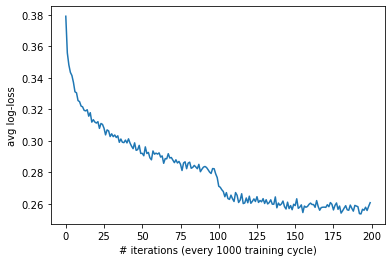

In [20]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))
plt.xlabel('# iterations (every 1000 training cycle)')
plt.ylabel('avg log-loss');

In [24]:
# put layers into eval mode
for layer in model.layers:
    layer.training = False

In [22]:
for layer in model.layers:
    print(layer.__class__.__name__, ':', tuple(layer.out.shape))

Embedding : (32, 8, 24)
FlattenConsecutive : (32, 4, 48)
Linear : (32, 4, 128)
BatchNorm1d : (32, 4, 128)
Tanh : (32, 4, 128)
FlattenConsecutive : (32, 2, 256)
Linear : (32, 2, 128)
BatchNorm1d : (32, 2, 128)
Tanh : (32, 2, 128)
FlattenConsecutive : (32, 256)
Linear : (32, 128)
BatchNorm1d : (32, 128)
Tanh : (32, 128)
Linear : (32, 27)


In [23]:
# evaluate the loss
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xval, Yval),
        'test': (Xte, Yte),
    }[split]
    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())
    
split_loss('train')
split_loss('val')

train 1.787521243095398
val 1.9916340112686157


In [26]:
# sample from the model
for _ in range(5):
    out = []
    context = [0] * block_size
    while True:
        logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0: break
    print(''.join(itos[i] for i in out))

mylieanro.
cleo.
karmen.
stibo.
marianah.


### LOG
* with 12K parameters
> train: 1.924\
val: 2.027

* after scaling up to 76K parameters
> train: 1.787\
val 1.991